In [94]:
import numpy as np # linear algebra
import pandas as pd # data processing
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [96]:
#Reading the dataset
data = pd.read_csv("/content/drive/MyDrive/covid_small.csv")

In [ ]:
data.columns

In [ ]:
for col in data.columns :
    print(data[col].value_counts())

In [98]:
col_list = ['USMER', 'SEX', 'PATIENT_TYPE', 'INTUBED',
       'PNEUMONIA', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'ICU']

In [99]:
#Converting the columns in col_list to three classes, 0 indicates No, 1 indicates Yes, 2 indicates no info or missing
for col in col_list :
    data[col].replace({2:0, 1:1, 97:2, 98:2, 99:2}, inplace = True)

In [ ]:
# Checking Value_counts of each column after class conversion
for col in col_list :
    print(data[col].value_counts())

In [101]:
#Converting the target feature into Binary, classes 1-3 converted to class 1 (indicates high risk), classes 4-7 converted to 0 (low risk)
data['CLASIFFICATION_FINAL'].replace({1:1, 2:1, 3:1, 4:0, 5:0, 6:0, 7:0}, inplace = True)

In [102]:
#Dropped below columns due to irrelevancy to the target variable
data = data.drop(columns = ['MEDICAL_UNIT', 'DATE_DIED'])

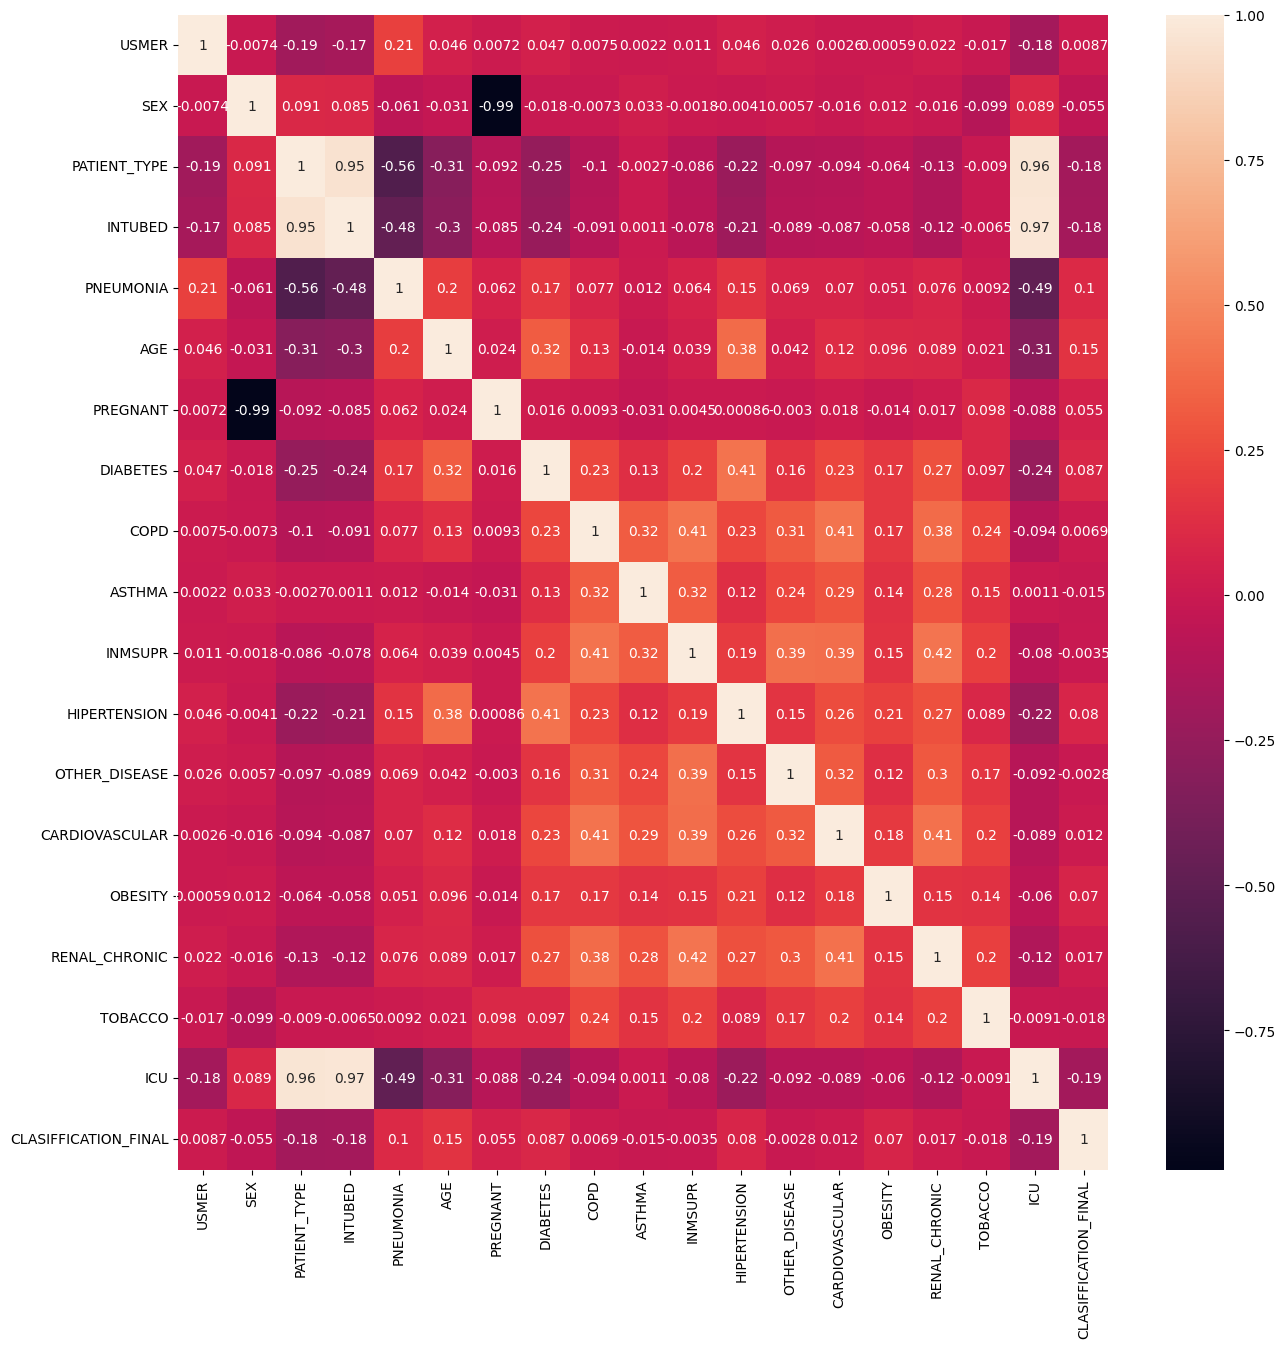

In [103]:
#Plotting Heatmap to check the corelation b/w variables
import seaborn as sns
import matplotlib.pyplot as plt
corr = data.corr()
plt.figure(figsize = (15,15))
sns.heatmap(corr, xticklabels = "auto", yticklabels ='auto', annot = True)
plt.show()

In [104]:
#Dropped INTUBED column due to high correlation with PATIENT_TYPE
#Seperated dependant and targer variables
X = data.drop(columns = ['CLASIFFICATION_FINAL', 'INTUBED'])
y= data['CLASIFFICATION_FINAL']

In [105]:
#Train-test split (80 - 20)
from sklearn.model_selection import train_test_split
X_train,X_test,y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [106]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [107]:

# Defining activation functions

def relu(x):
    return np.maximum(0, x)

def softmax(x):
    exps = np.exp(x - np.max(x))
    return exps / np.sum(exps, axis=1, keepdims=True)

# Define loss function
def cross_entropy_loss(y_true, y_pred):
    m = y_true.shape[0]
    y_true_indices = np.argmax(y_true, axis=1)
    log_likelihood = -np.log(y_pred[range(m), y_true_indices])
    loss = np.sum(log_likelihood) / m
    return loss

In [108]:
# Defining my neural network architectures
class NeuralNetwork:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.W1 = np.random.randn(self.input_dim, self.hidden_dim) * 0.01
        self.b1 = np.zeros((1, self.hidden_dim))
        self.W2 = np.random.randn(self.hidden_dim, self.output_dim) * 0.01
        self.b2 = np.zeros((1, self.output_dim))

    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = relu(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = softmax(self.z2)
        return self.a2

    def backward(self, X, y, learning_rate):
        m = X.shape[0]
        dz2 = self.a2 - y
        dw2 = np.dot(self.a1.T, dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m
        dz1 = np.dot(dz2, self.W2.T) * (self.a1 > 0)
        dw1 = np.dot(X.T, dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m

        # Updating weights and biases
        self.W1 -= learning_rate * dw1
        self.b1 -= learning_rate * db1
        self.W2 -= learning_rate * dw2
        self.b2 -= learning_rate * db2

In [109]:
# one-hot encoding function
def one_hot_encode(y, num_classes):
    one_hot_y = np.zeros((y.shape[0], num_classes))
    for i in range(y.shape[0]):
        one_hot_y[i, y[i]] = 1
    return one_hot_y

In [110]:
from sklearn.metrics import classification_report
#Model training loop
def train_model(X_train, y_train, X_test, y_test, hidden_dim, learning_rate):
    input_dim = X_train.shape[1]
    output_dim = len(np.unique(y_train))
    epochs = 100
    batch_size = 128
    steps_per_epoch = X_train.shape[0] // batch_size

    model = NeuralNetwork(input_dim, hidden_dim, output_dim)

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        # Shuffle training data
        indices = np.random.permutation(X_train.shape[0])
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train[indices]

        for step in range(steps_per_epoch):
            start = step * batch_size
            end = start + batch_size
            X_batch = X_train_shuffled[start:end]
            y_batch = y_train_shuffled[start:end]

            # One-hot encode batch_y
            y_batch = one_hot_encode(y_batch, output_dim)

            # Forward pass
            y_pred = model.forward(X_batch)

            # Compute loss
            loss = cross_entropy_loss(y_batch, y_pred)

            # Backpropagation
            model.backward(X_batch, y_batch, learning_rate)

        # Evaluate on training data
        y_train_onehot = one_hot_encode(y_train, output_dim)
        train_pred = np.argmax(model.forward(X_train), axis=1)
        train_loss = cross_entropy_loss(y_train_onehot, model.forward(X_train))
        train_accuracy = np.mean(train_pred == y_train)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Evaluate on test data
        y_test_onehot = one_hot_encode(y_test, output_dim)
        test_pred = np.argmax(model.forward(X_test), axis=1)
        test_loss = cross_entropy_loss(y_test_onehot, model.forward(X_test))
        test_accuracy = np.mean(test_pred == y_test)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

    # Generate classification report for all test predictions
    report = classification_report(y_test, test_pred)

    return train_losses, test_losses, train_accuracies, test_accuracies, report


In [111]:

learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]
hidden_dims = [0, 32, 64]

results = {}

for hidden_dim in hidden_dims:
    results[hidden_dim] = {}
    for lr in learning_rates:
        train_losses, test_losses, train_accuracies, test_accuracies, report = train_model(X_train, y_train, X_test, y_test, hidden_dim, lr)
        results[hidden_dim][lr] = {
            'train_losses': train_losses,
            'test_losses': test_losses,
            'train_accuracies': train_accuracies,
            'test_accuracies': test_accuracies,
            'classification_report': report
        }
        # After the learning rate loop, print the classification report for the current hidden dimension
        print(f"Classification report for hidden dimension {hidden_dim} learning rate{lr}:")
        print(report)

Classification report for hidden dimension 0 learning rate0.1:
              precision    recall  f1-score   support

           0       0.63      1.00      0.77     12607
           1       0.00      0.00      0.00      7393

    accuracy                           0.63     20000
   macro avg       0.32      0.50      0.39     20000
weighted avg       0.40      0.63      0.49     20000

Classification report for hidden dimension 0 learning rate0.01:
              precision    recall  f1-score   support

           0       0.63      1.00      0.77     12607
           1       0.00      0.00      0.00      7393

    accuracy                           0.63     20000
   macro avg       0.32      0.50      0.39     20000
weighted avg       0.40      0.63      0.49     20000

Classification report for hidden dimension 0 learning rate0.001:
              precision    recall  f1-score   support

           0       0.63      1.00      0.77     12607
           1       0.00      0.00      0.00  

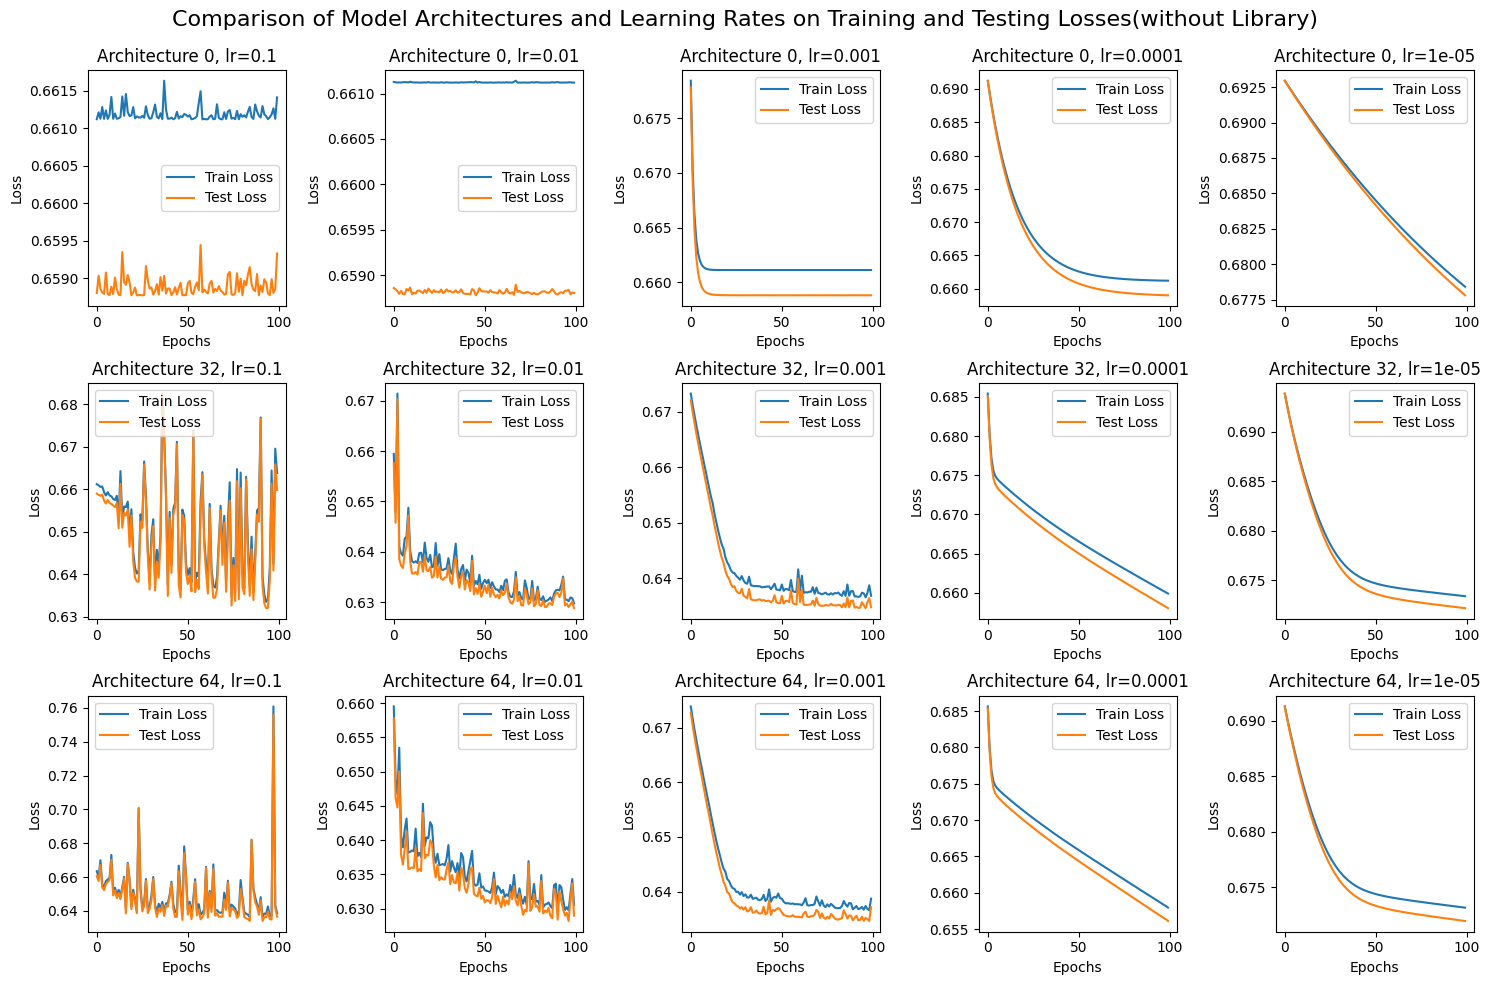

In [112]:
num_hidden_dims = len(hidden_dims)
num_learning_rates = len(learning_rates)

fig, axs = plt.subplots(num_hidden_dims, num_learning_rates, figsize=(15, 10))

for i, hidden_dim in enumerate(hidden_dims):
    for j, lr in enumerate(learning_rates):
        ax = axs[i, j]
        ax.plot(results[hidden_dim][lr]['train_losses'], label="Train Loss")
        ax.plot(results[hidden_dim][lr]['test_losses'], label="Test Loss")
        ax.set_title(f"Architecture {hidden_dim}, lr={lr}")
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Loss")
        ax.legend()

plt.tight_layout()
plt.suptitle('Comparison of Model Architectures and Learning Rates on Training and Testing Losses(without Library)', fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show()

In [113]:
test_loss_list = []
for hidden_dim in hidden_dims:
    for lr in learning_rates:
        test_loss = results[hidden_dim][lr]['test_losses'][-1]
        test_loss_list.append(test_loss)

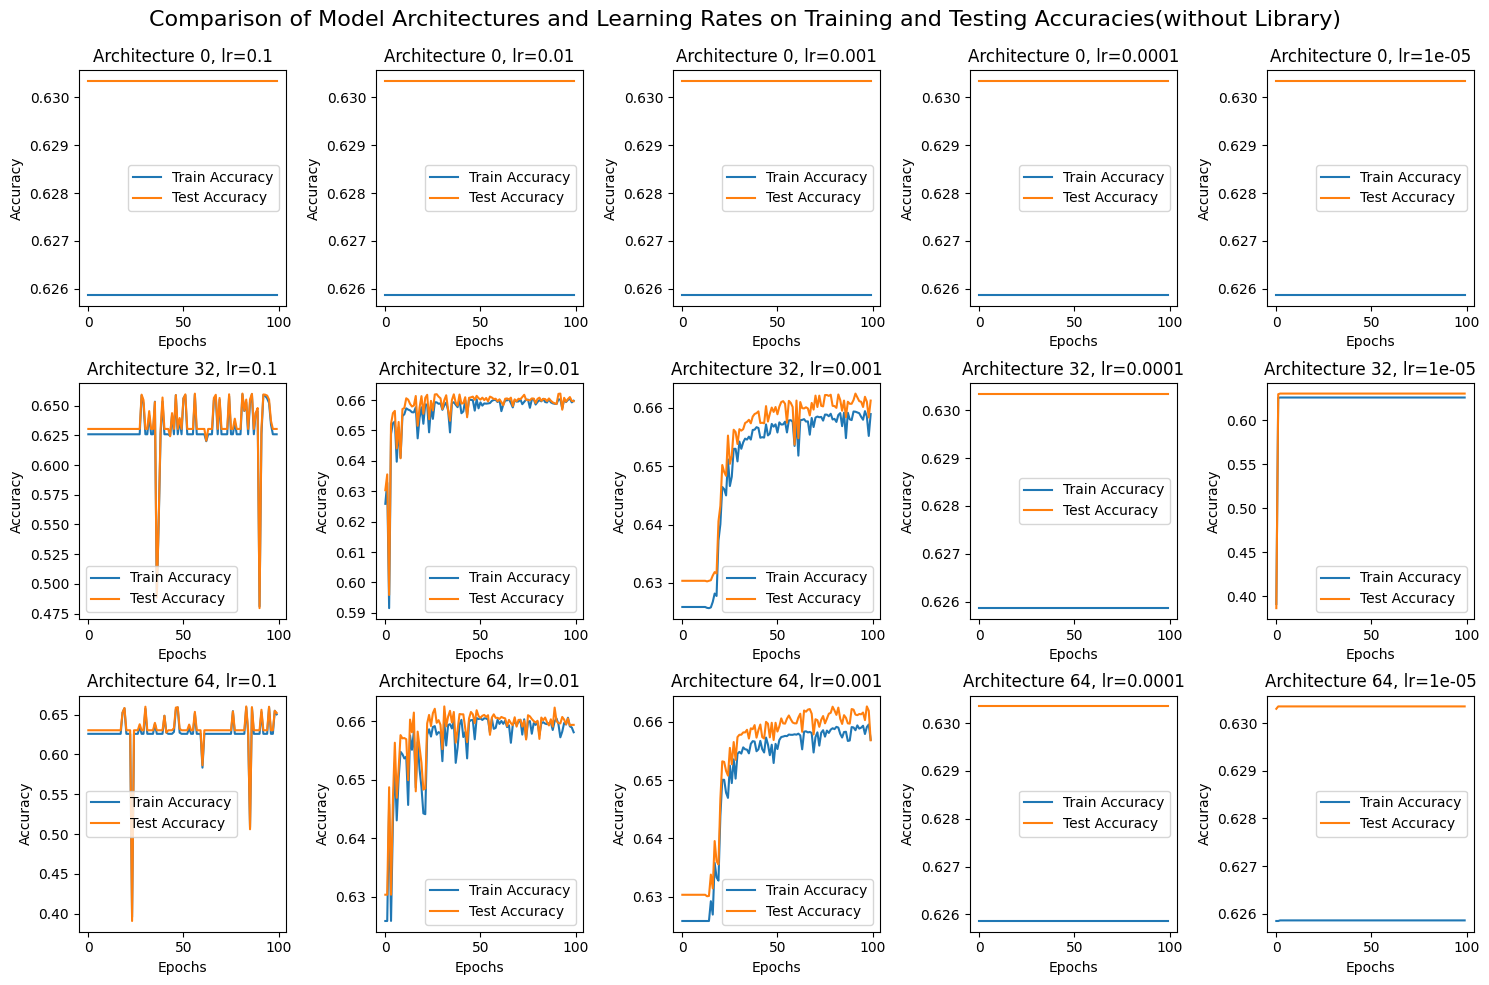

In [114]:

fig, axs = plt.subplots(num_hidden_dims, num_learning_rates, figsize=(15, 10))

for i, hidden_dim in enumerate(hidden_dims):
    for j, lr in enumerate(learning_rates):
        ax = axs[i, j]
        ax.plot(results[hidden_dim][lr]['train_accuracies'], label= "Train Accuracy")
        ax.plot(results[hidden_dim][lr]['test_accuracies'], label= "Test Accuracy")
        ax.set_title(f"Architecture {hidden_dim}, lr={lr}")
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Accuracy")
        ax.legend()

plt.tight_layout()
plt.suptitle('Comparison of Model Architectures and Learning Rates on Training and Testing Accuracies(without Library)', fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show()

In [115]:
test_accuracy_list = []
for hidden_dim in hidden_dims:
    for lr in learning_rates:
        test_accuracy = results[hidden_dim][lr]['test_accuracies'][-1]*100
        test_accuracy_list.append(test_accuracy)

In [116]:
import torch
import torch.nn as nn
import torch.optim as optim

In [117]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [118]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [119]:

# Define neural network architectures
class Model(nn.Module):
    def __init__(self, input_size, hidden_size=None):
        super(Model, self).__init__()
        if hidden_size is None:
            self.fc = nn.Linear(input_size, output_size)
        else:
            self.fc1 = nn.Linear(input_size, hidden_size)
            self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        if hasattr(self, 'fc'):
            x = self.fc(x)
        else:
            x = self.fc1(x)
            x = self.relu(x)
            x = self.fc2(x)
        return self.softmax(x)

In [120]:

# Define training function
def train_model_pytorch(model, criterion, optimizer, X_train, y_train, X_test, y_test, num_epochs, batch_size):
    train_loss_history = []
    test_loss_history = []
    train_accuracy_history = []
    test_accuracy_history = []

    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        train_loss = train_loss / total_train
        train_accuracy = correct_train / total_train
        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)

        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            outputs = model(X_test)
            loss = criterion(outputs, y_test)
            test_loss = loss.item()
            _, predicted = torch.max(outputs, 1)
            total_test += y_test.size(0)
            correct_test += (predicted == y_test).sum().item()
        test_accuracy = correct_test / total_test
        test_loss_history.append(test_loss)
        test_accuracy_history.append(test_accuracy)

    # Generate classification report
    test_predictions = predicted.numpy()
    report = classification_report(y_test.numpy(), test_predictions)

    return train_loss_history, test_loss_history, train_accuracy_history, test_accuracy_history, report

In [121]:
# Define hyperparameters
input_size = X_train.shape[1]
output_size = len(np.unique(y_train))
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]
num_epochs = 100
batch_size = 128


In [122]:

# Train and evaluate models for different architectures and learning rates
architectures = [(input_size,), (input_size, 32), (input_size, 64)]
result = {}

for i, architectures  in enumerate(architectures):
    result[architectures] = {}

    for lr in learning_rates:
        model = Model(*architectures)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=lr)
        train_loss_history, test_loss_history, train_accuracy_history, test_accuracy_history, report = train_model_pytorch(
            model, criterion, optimizer, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, num_epochs, batch_size)

        result[architectures][lr] = {
          'Train Loss': train_loss_history,
          'Test Loss': test_loss_history,
          'Train Accuracy': train_accuracy_history,
          'Test Accuracy': test_accuracy_history,
          'Classification Reort' : report
        }
        # After the learning rate loop, print the classification report for the current hidden dimension
        print(f"Classification report for Architecture {architectures} learning rate {lr}:")
        print(report)


Classification report for Architecture (17,) learning rate 0.1:
              precision    recall  f1-score   support

           0       0.63      1.00      0.77     12607
           1       0.00      0.00      0.00      7393

    accuracy                           0.63     20000
   macro avg       0.32      0.50      0.39     20000
weighted avg       0.40      0.63      0.49     20000

Classification report for Architecture (17,) learning rate 0.01:
              precision    recall  f1-score   support

           0       0.63      1.00      0.77     12607
           1       0.00      0.00      0.00      7393

    accuracy                           0.63     20000
   macro avg       0.32      0.50      0.39     20000
weighted avg       0.40      0.63      0.49     20000

Classification report for Architecture (17,) learning rate 0.001:
              precision    recall  f1-score   support

           0       0.67      0.90      0.77     12607
           1       0.59      0.24      0.3

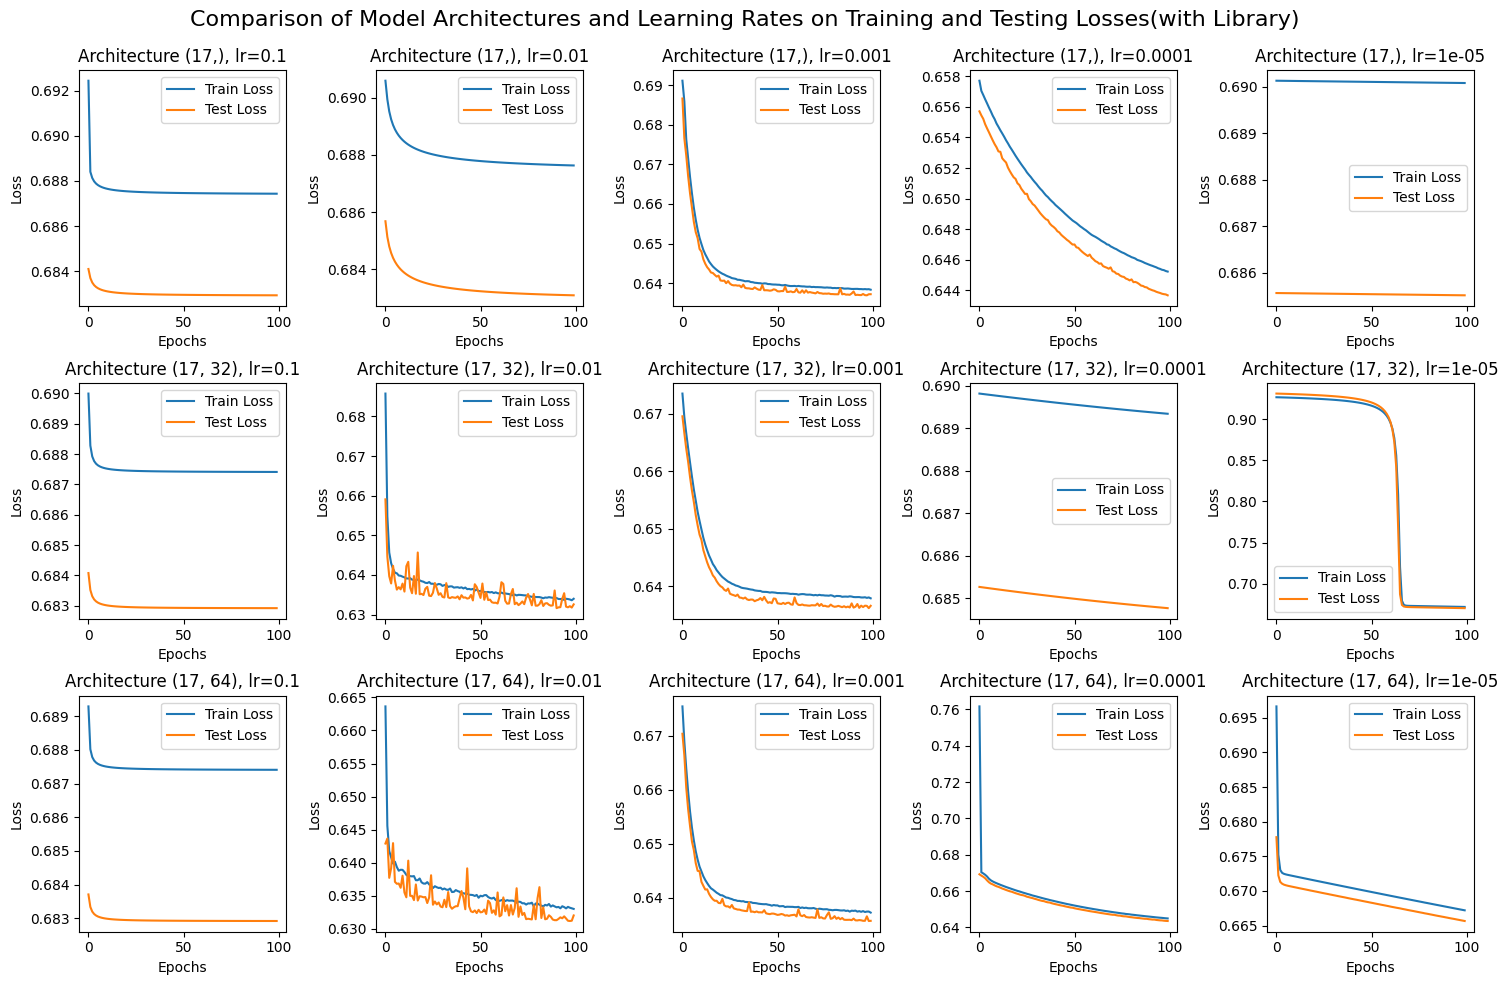

In [133]:
model_architectures = [(17,), (17, 32), (17, 64)]
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]

fig, axs = plt.subplots(len(model_architectures), len(learning_rates), figsize=(15, 10))

for i, architecture in enumerate(model_architectures):
    for j, lr in enumerate(learning_rates):
        ax = axs[i, j]
        ax.plot(result[architecture][lr]['Train Loss'], label="Train Loss")
        ax.plot(result[architecture][lr]['Test Loss'], label="Test Loss")
        ax.set_title(f"Architecture {architecture}, lr={lr}")
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Loss")
        ax.legend()

plt.tight_layout()
plt.suptitle('Comparison of Model Architectures and Learning Rates on Training and Testing Losses(with Library)', fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show()

In [124]:
test_loss_with_lib_list = []
for i, architecture in enumerate(model_architectures):
    for j, lr in enumerate(learning_rates):
        test_loss_with_lib = result[architecture][lr]['Test Loss'][-1]
        test_loss_with_lib_list.append(test_loss_with_lib)

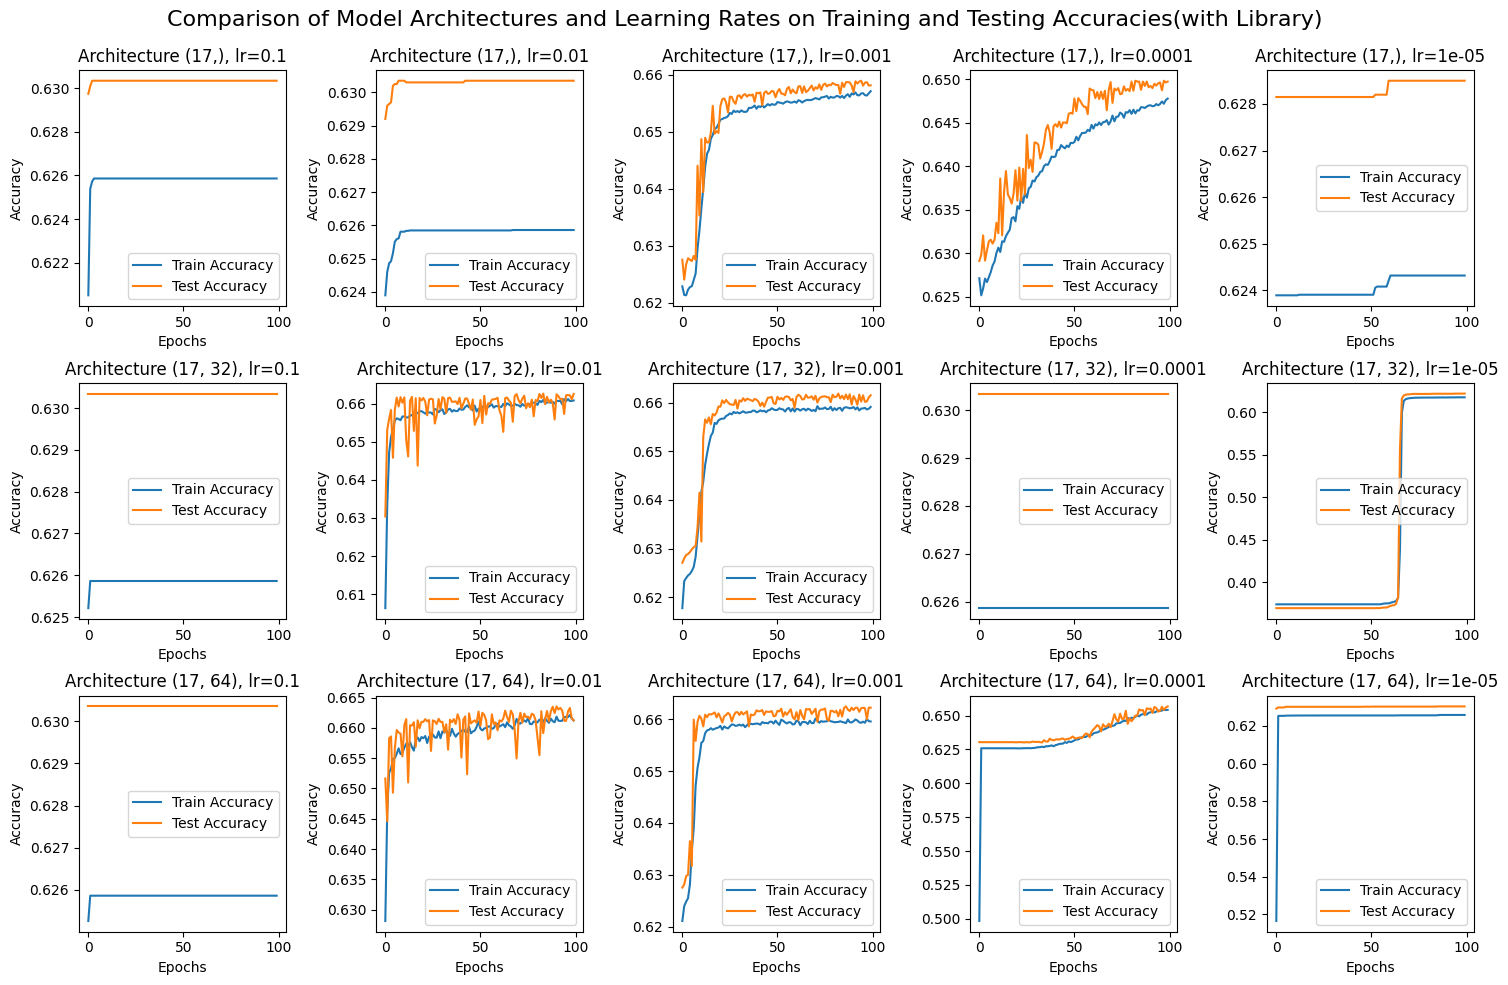

In [125]:
fig, axs = plt.subplots(len(model_architectures), len(learning_rates), figsize=(15, 10))

for i, architecture in enumerate(model_architectures):
    for j, lr in enumerate(learning_rates):
        ax = axs[i, j]
        ax.plot(result[architecture][lr]['Train Accuracy'], label="Train Accuracy")
        ax.plot(result[architecture][lr]['Test Accuracy'], label="Test Accuracy")
        ax.set_title(f"Architecture {architecture}, lr={lr}")
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Accuracy")
        ax.legend()

plt.tight_layout()
plt.suptitle('Comparison of Model Architectures and Learning Rates on Training and Testing Accuracies(with Library)', fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show()

In [126]:
test_accuracy_with_lib_list = []
for i, architecture in enumerate(model_architectures):
    for j, lr in enumerate(learning_rates):
        test_accuracy_with_lib = result[architecture][lr]['Test Accuracy'][-1]*100
        test_accuracy_with_lib_list.append(test_accuracy_with_lib)

In [127]:
model_list = ['Architecture 0','Architecture 0','Architecture 0','Architecture 0','Architecture 0','Architecture 32','Architecture 32','Architecture 32','Architecture 32','Architecture 32','Architecture 64','Architecture 64','Architecture 64','Architecture 64',
 'Architecture 64']

In [128]:
Learning_rate_list = [0.1,0.01,0.001,0.0001,1e-05,0.1,0.01,0.001, 0.0001, 1e-05, 0.1,0.01,0.001, 0.0001, 1e-05]

In [129]:
Data = {'Model':model_list, 'Learning Rate' : Learning_rate_list, 'TestLoss' : test_loss_list, 'TestLoss with lib' : test_loss_with_lib_list, 'TestAccuracy' : test_accuracy_list, 'TestAccuracy with lib' : test_accuracy_with_lib_list }
result_df = pd.DataFrame(Data)

In [130]:
result_df

,Model,Learning Rate,TestLoss,TestLoss with lib,TestAccuracy,TestAccuracy with lib
0,Architecture 0,0.10000,0.659329,0.682931,63.035,63.035
1,Architecture 0,0.01000,0.658803,0.683086,63.035,63.035
2,Architecture 0,0.00100,0.658811,0.637192,63.035,65.815
3,Architecture 0,0.00010,0.659010,0.643685,63.035,64.975
4,Architecture 0,0.00001,0.677813,0.685514,63.035,62.850
5,Architecture 32,0.10000,0.659810,0.682918,63.035,63.035
6,Architecture 32,0.01000,0.628792,0.632578,65.965,66.255
7,Architecture 32,0.00100,0.634746,0.636553,66.125,66.150
8,Architecture 32,0.00010,0.658031,0.684771,63.035,63.035
9,Architecture 32,0.00001,0.672176,0.670415,63.035,62.190
